<a href="https://colab.research.google.com/github/kangjw1208/Ethereum_Prediction/blob/main/LSTM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Notebook

To combat the simplicity of the traditional time series model, Long Short Term Memory (LSTM) network, a type of recurrent neural network, was used. This modeling technique was chosen because it is currently one of the most sophisticated models that can handle sequential data. To briefly explain the benefit of this architecture, LSTM neuron takes information from previous cells and combines it with newly input datas. It then quickly determines how much of the combined information is worth “retaining” or “forgetting”. This constant adjustment of weights produces a deep learning model that could potentially identify the underlying random patterns.

---

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
df_d = pd.read_csv('https://raw.githubusercontent.com/kangjw1208/Ethereum_Prediction/main/data/Binance_ETHUSDT_d.csv')
df_h = pd.read_csv('https://raw.githubusercontent.com/kangjw1208/Ethereum_Prediction/main/data/Binance_ETHUSDT_1h.csv')

In [4]:
#Function to transform daily ethereum data into a time series data frame with date time index
def to_datetime_day(df):
    
    df.reset_index(inplace=True)
    df.columns = df.iloc[0]
    df.drop(index = df.index[0:2], axis=0, inplace=True)
    
    df['date'] = df['date'].str[0:10]
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    df.set_index('date', inplace = True)
    
    df.drop(df.columns[[0,1,-1,-2]], axis=1, inplace=True)
    
    for x in df.columns:
        df[x] = df[x].astype(float)
    
    return df

In [5]:
#Function to transform hourly ethereum data into a time series data frame with date time index
def to_datetime_hour(df):
    
    df.reset_index(inplace=True)
    df.columns = df.iloc[0]
    df.drop(index = df.index[0:2], axis=0, inplace=True)
    
    def datetime_func(x):
        if 'AM' in x:
            return pd.to_datetime(x[0:13]+':00:00 AM').strftime('%Y-%m-%d %H:%M:%S')
        elif 'PM' in x:
            return pd.to_datetime(x[0:13]+':00:00 PM').strftime('%Y-%m-%d %H:%M:%S')
        else:
            return pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S')
    
    df['date'] = df['date'].apply(datetime_func)
    df.set_index('date', inplace = True)
    df.drop(df.columns[[0,1,-1,-2]], axis=1, inplace=True)
    
    for x in df.columns:
        df[x] = df[x].astype(float)
    
    return df

In [6]:
to_datetime_day(df_d)

,open,high,low,close,Volume ETH
date,,,,,
2022-01-10,3151.97,3185.00,2928.83,3082.68,529818.3866
2022-01-09,3080.98,3211.72,3057.35,3151.97,275874.1643
2022-01-08,3198.68,3250.00,3000.00,3080.95,400692.1061
2022-01-07,3406.81,3416.76,3064.42,3199.24,669631.7262
2022-01-06,3539.82,3550.43,3300.00,3406.81,496745.7413
...,...,...,...,...,...
2017-08-21,299.10,346.52,294.60,323.29,5134.5400
2017-08-20,290.91,300.53,282.85,299.10,2469.4900
2017-08-19,293.96,299.90,278.00,290.91,2140.0800


In [7]:
to_datetime_hour(df_h)

,open,high,low,close,Volume ETH
date,,,,,
2022-01-10 23:00:00,3062.73,3088.01,3054.06,3082.68,9189.4677
2022-01-10 22:00:00,3074.65,3084.96,3056.33,3062.73,6294.9157
2022-01-10 21:00:00,3082.68,3096.15,3068.12,3074.65,13234.7443
2022-01-10 20:00:00,3029.75,3088.00,3019.17,3082.68,15604.1474
2022-01-10 19:00:00,3042.90,3056.28,3020.21,3029.75,10499.1698
...,...,...,...,...,...
2017-08-17 08:00:00,307.96,309.97,307.00,308.62,150.7500
2017-08-17 07:00:00,302.68,307.96,302.60,307.96,753.1900
2017-08-17 06:00:00,303.10,304.44,301.90,302.68,302.5100


In [ ]:
#Creating daily and weekly resampled target variable
target_day = df_d['close'].resample('D').mean()
target_week = df_d['close'].resample('W').mean()

## Reshaping/Preprocessing Data

Unlike the simple time series model such as ARIMA and SARIMA, LSTM, a type of recurrent neural network models require a three dimensional data shape. The reason is that the model has to train by capturing the patterns in the historical look back step size and it iterates forward one step at a time until either all of the training or testing data is run through. Also it is important to minmax scale the data for the model to run properly. Below are functions that reshapes a simple array into three dimensional shape and scales the data.

In [9]:
#Function that converts the data into a matrix form that is compatible to LSTM model
def convert_matrix(data, step_size):
   X=list()
   Y=list()
   for i in range(len(data)-step_size):
    d=i+step_size  
    X.append(data[i:d,])
    Y.append(data[d,])
   return np.array(X), np.array(Y)

In [10]:
#Function that scales the data into MinMaxScaler with range of 0 to 1
def minmaxscaler(data):
  target= data.values 
  target = np.reshape(target, (-1, 1)) #LTSM requires more input features compared to RNN or DNN
  scaler = MinMaxScaler(feature_range=(0, 1))#LTSM is senstive to the scale of features
  target = scaler.fit_transform(target)
  return target

In [11]:
#Function to split the data into training and test data
def train_test_split(data, ratio):
    train_size = int(len(data) * ratio)
    train, test = data[0:train_size], data[train_size:]
    return train, test

## LSTM Model

This lstm model consists of three hidden layers. One of the layer consists of the dropout layer in order to regulate the model controlling the possibility of overfitting. The best performing lstm model had a both epoch size and batch size of 100.

### Daily Dataset

In [12]:
#Function that runs lstm model by taking in the data and returning rmse and test prediction
def lstm_model(data, step_size):

  target = data.values 
  target = np.reshape(target, (-1, 1))
  scaler = MinMaxScaler(feature_range=(0, 1))
  target = scaler.fit_transform(target)

  train, test = train_test_split(target, 0.8)

  X_train, y_train = convert_matrix(train, step_size)
  X_test, y_test = convert_matrix(test, step_size)

  X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
  X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

  model = Sequential()
  model.add(LSTM(units = 200, activation='relu', return_sequences=True,  input_shape=(X_train.shape[1], step_size)))
  model.add(Dropout(0.2)) 
  model.add(LSTM(units = 150, activation = 'relu'))
  model.add(Dense(units =1))
  model.compile(optimizer='adam', loss='mean_squared_error')

  model.fit(X_train, y_train, epochs=100, batch_size=100, validation_data=(X_test, y_test), verbose=1)

  train_predict = model.predict(X_train)
  test_predict = model.predict(X_test)

  train_predict = scaler.inverse_transform(train_predict)
  test_predict = scaler.inverse_transform(test_predict)
  y_train = scaler.inverse_transform(y_train)
  y_test = scaler.inverse_transform(y_test)

  rmse_train = np.sqrt(mean_squared_error(y_train, train_predict))
  rmse_test = np.sqrt(mean_squared_error(y_test, test_predict))


  return rmse_train, rmse_test, test_predict

In [13]:
rmse_train, rmse_test, test_predict_daily = lstm_model(target_day, 100)

Epoch 1/100
12/12 [==============================] - 4s 53ms/step - loss: 0.0049 - val_loss: 0.0333
Epoch 2/100
12/12 [==============================] - 0s 17ms/step - loss: 0.0023 - val_loss: 0.0146
Epoch 3/100
12/12 [==============================] - 0s 19ms/step - loss: 0.0012 - val_loss: 0.4138
Epoch 4/100
12/12 [==============================] - 0s 18ms/step - loss: 6.0196e-04 - val_loss: 0.4013
Epoch 5/100
12/12 [==============================] - 0s 19ms/step - loss: 5.0114e-04 - val_loss: 0.2291
Epoch 6/100
12/12 [==============================] - 0s 18ms/step - loss: 3.7878e-04 - val_loss: 0.1713
Epoch 7/100
12/12 [==============================] - 0s 17ms/step - loss: 3.3873e-04 - val_loss: 0.1188
Epoch 8/100
12/12 [==============================] - 0s 18ms/step - loss: 2.8401e-04 - val_loss: 0.0548
Epoch 9/100
12/12 [==============================] - 0s 19ms/step - loss: 2.7650e-04 - val_loss: 0.0343
Epoch 10/100
12/12 [==============================] - 0s 17ms/step - loss: 2

In [14]:
train, test = train_test_split(target_day, 0.8)

#Creating a dataframe with proper datetime index and the prediction value returned from the function
x = len(test_predict_daily)
predict_index = test.index[-x:]
df_prediction = pd.DataFrame(test_predict_daily, index = predict_index, columns = ['prediction'])

RMSE: 460.86


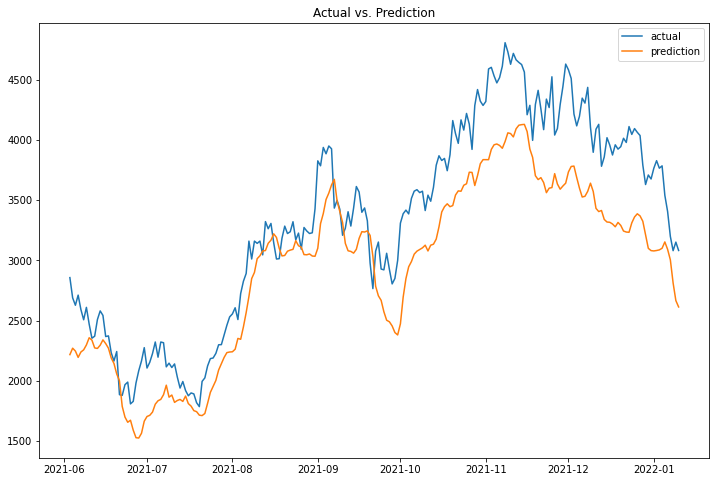

In [15]:
#Plotting the graph that compares actual price to predicted price
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(test[-len(df_prediction):], label='actual')
ax.plot(df_prediction['prediction'], label='prediction')
ax.set_title('Actual vs. Prediction');
plt.legend();
print("RMSE:",round(rmse_test,2))

### Hourly Dataset

In [16]:
#Resampling the data hourly
target_hour = df_h['close'].resample('H').mean()
t = target_hour[-2000:]

In [17]:
#Running the lstm prediction function
rmse_train, rmse_test, test_predict_hourly = lstm_model(t, 100)

Epoch 1/100
15/15 [==============================] - 2s 41ms/step - loss: 0.2226 - val_loss: 0.0108
Epoch 2/100
15/15 [==============================] - 0s 16ms/step - loss: 0.0316 - val_loss: 0.0079
Epoch 3/100
15/15 [==============================] - 0s 16ms/step - loss: 0.0168 - val_loss: 0.0080
Epoch 4/100
15/15 [==============================] - 0s 16ms/step - loss: 0.0125 - val_loss: 0.0083
Epoch 5/100
15/15 [==============================] - 0s 17ms/step - loss: 0.0101 - val_loss: 0.0097
Epoch 6/100
15/15 [==============================] - 0s 16ms/step - loss: 0.0089 - val_loss: 0.0100
Epoch 7/100
15/15 [==============================] - 0s 16ms/step - loss: 0.0082 - val_loss: 0.0105
Epoch 8/100
15/15 [==============================] - 0s 16ms/step - loss: 0.0071 - val_loss: 0.0105
Epoch 9/100
15/15 [==============================] - 0s 17ms/step - loss: 0.0069 - val_loss: 0.0111
Epoch 10/100
15/15 [==============================] - 0s 15ms/step - loss: 0.0062 - val_loss: 0.0121

In [18]:
trainn, testt = train_test_split(t, 0.8)

#Creating a dataframe with proper datetime index and the prediction value returned from the function
x = len(test_predict_hourly)
predict_index = testt.index[-x:]
df_prediction = pd.DataFrame(test_predict_hourly, index = predict_index, columns = ['prediction'])

RMSE: 175.95


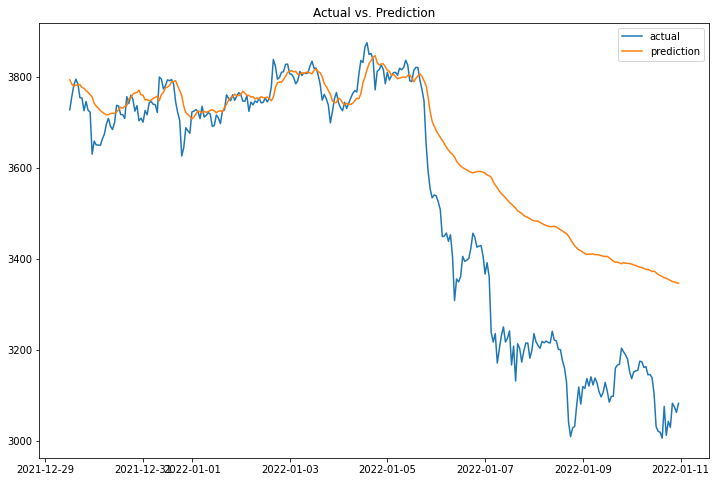

In [19]:
#Plotting the comparison of actual and predicted ethereum price
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(testt[-len(df_prediction):], label='actual')
ax.plot(df_prediction['prediction'], label='prediction')
ax.set_title('Actual vs. Prediction');
plt.legend();
print("RMSE:",round(rmse_test,2))

### Future Forecast

In [159]:
#creating a dataframe with updated ethereum price
df_hour = pd.read_csv('https://raw.githubusercontent.com/kangjw1208/Ethereum_Prediction/main/data/Binance_ETHUSDT_1h_updated.csv')

In [160]:
to_datetime_hour(df_hour)

,open,high,low,close,Volume ETH
date,,,,,
2022-01-26 23:00:00,2438.19,2477.00,2433.10,2462.99,27816.6238
2022-01-26 22:00:00,2417.95,2442.97,2402.03,2438.18,28348.2075
2022-01-26 21:00:00,2519.74,2534.34,2412.67,2417.95,38562.5750
2022-01-26 20:00:00,2573.84,2573.84,2469.54,2519.12,86865.1418
2022-01-26 19:00:00,2604.89,2722.00,2564.00,2573.83,151949.4512
...,...,...,...,...,...
2017-08-17 08:00:00,307.96,309.97,307.00,308.62,150.7500
2017-08-17 07:00:00,302.68,307.96,302.60,307.96,753.1900
2017-08-17 06:00:00,303.10,304.44,301.90,302.68,302.5100


In [161]:
df_hour = df_hour['close'].resample('H').mean()

In [162]:
df_hour

date
2017-08-17 04:00:00     300.79
2017-08-17 05:00:00     303.10
2017-08-17 06:00:00     302.68
2017-08-17 07:00:00     307.96
2017-08-17 08:00:00     308.62
                        ...   
2022-01-26 19:00:00    2573.83
2022-01-26 20:00:00    2519.12
2022-01-26 21:00:00    2417.95
2022-01-26 22:00:00    2438.18
2022-01-26 23:00:00    2462.99
Freq: H, Name: close, Length: 38972, dtype: float64

In [163]:
#Function that runs the same exact lstm model with the same hyperparameter and returns the predicted price
def forecast_price(data, step_size, hour):

  target = data.values 
  target = np.reshape(target, (-1, 1))
  scaler = MinMaxScaler(feature_range=(0, 1))
  target = scaler.fit_transform(target)

  X_train, y_train = convert_matrix(target, step_size)

  X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

  model = Sequential()
  model.add(LSTM(units = 200, activation='relu', return_sequences=True,  input_shape=(X_train.shape[1], step_size)))
  model.add(Dropout(0.2)) 
  model.add(LSTM(units = 150, activation = 'relu'))
  model.add(Dense(units =1))
  model.compile(optimizer='adam', loss='mean_squared_error')

  model.fit(X_train, y_train, epochs=100, batch_size=100, verbose=1)

  x_predict = target[-step_size:]
  prediction = list()
  for i in range(0, hour):
    x_predict = x_predict.reshape(1, 1, int(x_predict.shape[0]))
    yhat = model.predict(x_predict)
    unscaled = scaler.inverse_transform(yhat)
    unscaled = unscaled.tolist()
    unscaled = unscaled[0][0]
    prediction.append(unscaled)
    x_predict = np.append(x_predict, yhat)
    x_predict = x_predict[1:]

  return prediction

**Note**
Forecasting for lstm models are lot trickier than a standard time series model. In lstm forecast, the last portion of the data is fed into the model to predict one value into the future. It is important to keep the input data shape constant so after adding on that predicted value into the input array for second prediction, the first data point in that input data has to be sliced out.

In [164]:
data_pred = df_hour[-1600:]

In [165]:
prediction = forecast_price(data_pred, 100, 24)

Epoch 1/100
15/15 [==============================] - 2s 16ms/step - loss: 0.1529
Epoch 2/100
15/15 [==============================] - 0s 14ms/step - loss: 0.0178
Epoch 3/100
15/15 [==============================] - 0s 14ms/step - loss: 0.0105
Epoch 4/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0073
Epoch 5/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0067
Epoch 6/100
15/15 [==============================] - 0s 15ms/step - loss: 0.0064
Epoch 7/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0058
Epoch 8/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0053
Epoch 9/100
15/15 [==============================] - 0s 15ms/step - loss: 0.0044
Epoch 10/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0038
Epoch 11/100
15/15 [==============================] - 0s 14ms/step - loss: 0.0034
Epoch 12/100
15/15 [==============================] - 0s 14ms/step - loss: 0.0033
Epoch 13/100
15/15 [=====

In [166]:
date_index = pd.date_range(start=df_hour.index[-1], periods=25, freq='H')

In [167]:
date_index = date_index[1:]

In [168]:
df_pred = pd.DataFrame(prediction, index = date_index, columns = ['price'])

In [169]:
#The data obtained had a slight error in the price by about 100 dollars so this is to compensate for that error
df_pred['price_adjust'] = df_pred['price'] - 100

In [170]:
df_pred

,price,price_adjust
2022-01-27 00:00:00,2543.372314,2443.372314
2022-01-27 01:00:00,2542.707031,2442.707031
2022-01-27 02:00:00,2553.189697,2453.189697
2022-01-27 03:00:00,2568.769531,2468.769531
2022-01-27 04:00:00,2576.916016,2476.916016
2022-01-27 05:00:00,2586.309082,2486.309082
2022-01-27 06:00:00,2592.362549,2492.362549
2022-01-27 07:00:00,2599.671631,2499.671631
2022-01-27 08:00:00,2612.407471,2512.407471
2022-01-27 09:00:00,2617.577148,2517.577148


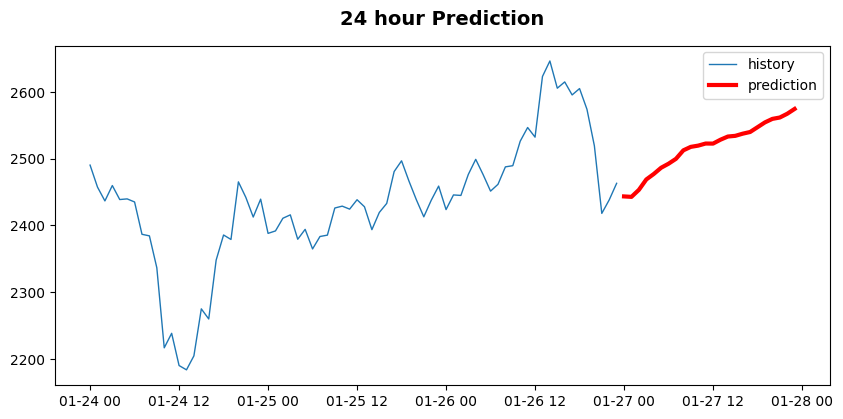

In [182]:
#Plotting the forecast data along with the historical data
fig, ax = plt.subplots(figsize=(10,4.5), dpi=100)
ax.plot(df_hour[-72:], label = 'history', linewidth=1)
ax.plot(df_pred['price_adjust'], label = 'prediction', c='red', linewidth=3)
ax.legend()
ax.set_title("24 hour Prediction", fontweight='bold', fontsize=14, pad=15);